# 2. Eigengesichter

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%load_ext version_information

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


### a) Laden Sie sich den oben angegebenen Datensatz herunter. Erstellen Sie ein Python- Skript, dass die Verzeichnisse des Datensatzes durchsucht und die Personen ermittelt, für die mindestens 70 Bilder existieren. Die dafür geeigneten Funktionen finden sich im Standardmodul os bzw. os.path.

In [9]:
import os
import tarfile
from urllib.request import urlretrieve

lfw_filename = 'lfw-funneled.tgz'
lfw_directory = '.lfw-dataset'

if not os.path.isfile(lfw_filename):
    print("Downloading")
    urlretrieve('http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz',filename = lfw_filename)

if not os.path.isdir(lfw_directory):
    # Dateien in das Zielverzeichnis extrahieren
    with tarfile.open(lfw_filename, 'r:gz') as tar:
        tar.extractall(path=lfw_directory)

min_images_required = 70
selected_persons = []
extracted_path = ".lfw-dataset/lfw_funneled"

# Verzeichnis durchsuchen
for person_folder in os.listdir(extracted_path):
    person_path = os.path.join(extracted_path, person_folder)

    if os.path.isdir(person_path):
        # Anzahl der Bilder fuer die aktuelle Person zaehlen
        num_images = len([f for f in os.listdir(person_path) if f.endswith('.jpg')])

        # Ueberpruefen, ob Mindestanzahl erreicht
        if num_images >= min_images_required:
            selected_persons.append({
                'person_name': person_folder,
                'num_images': num_images
            })

print(f"Personen mit mindestens {min_images_required} Bildern:")
for person_info in selected_persons:
    print(f"{person_info['person_name']}: {person_info['num_images']} Bilder")

Personen mit mindestens 70 Bildern:
Ariel_Sharon: 77 Bilder
Colin_Powell: 236 Bilder
Donald_Rumsfeld: 121 Bilder
George_W_Bush: 530 Bilder
Gerhard_Schroeder: 109 Bilder
Hugo_Chavez: 71 Bilder
Tony_Blair: 144 Bilder


### b) Erstellen Sie ein Python-Skript, das alle Bilder bis auf eines pro Person (diese werden später zum Testen des Klassifikators gebraucht) dieser am häufigsten abgebildeten Personen lädt, diese in Vektoren stackt und dann in einer gemeinsamen Designmatrix ablegt. Zum Laden der Bilder in Numpy-Arrays verwenden Sie am einfachsten das Modul scikit-image. Schneiden Sie zunächst einen einheitlichen zentralen Ausschnitt aus, der nur Augen und Mund enthält. Skalieren Sie die Bilder auf die Größe 32 × 32. Achten Sie darauf, vorher die Farbbilder in Grauwerte umzuwandeln (z.B. mit der Option as_gray = True) Legen Sie zusätzlich einen Vektor an, in dem der Name der Person (d.h. der Ordnername) für jede Zeile steht. Führen Sie die gleiche Art der Verarbeitung mit dem übrig gebliebenen Testbild pro Person durch und speichern Sie diese getrennt ab.

In [10]:
from skimage import io, transform
train_data = []
train_data_name = []
test_data = []
test_data_name = []

# Daten verarbeiten
for person in selected_persons:
    person_folder = person['person_name']
    person_path = os.path.join(extracted_path, person_folder)
    train_person_data = []
    test_person_data = []
    first = True

    # Bilder laden
    for filename in os.listdir(person_path):
        if filename.endswith('.jpg'):
            image_path = os.path.join(person_path, filename)
            # Laden und in Graustufen konvertieren
            img = io.imread(image_path, as_gray=True)
            # Augen und Mund ausschneiden
            img = img[90:185,80:170]
            # Skalieren auf 32x32
            img = transform.resize(img, (32, 32))
            # In einen Vektor packen
            img_vector = img.flatten()

            if (first):
                test_person_data.append(img_vector)
                test_data_name.append(person_folder)
                first = False
            else:
                train_person_data.append(img_vector)
                train_data_name.append(person_folder)

    # Trainingsdaten in einer gemeinsamen Designmatrix speichern
    train_person_data = np.array(train_person_data)
    train_data.append(train_person_data)

    # Testdaten getrennt abspeichern
    test_person_data = np.array(test_person_data)
    test_data.append(test_person_data)

### c) Wenden Sie nun Ihre Hauptkomponentenanalyse aus Arbeitsblatt 1 auf Ihre Designmatrix (Achtung: kopieren Sie alle Trainingsbilder für alle Personen als Zeilen in eine gemeinsame Designmatrix!) an. Stellen Sie die ersten 150 Eigenwerte in einem Diagramm und die ersten 12 Eigengesichter durch Umformung der gestackten Darstellung in das ursprüngliche Bildformat dar. Interpretieren Sie das Ergebnis.

In [11]:
X = pd.DataFrame(np.concatenate(train_data, axis=0))

from pca import pca
num_components = len(X.columns)
X_pca, Sigma, V = pca(X, num_components)

# Umrechnung von Singulärwerten in Eigenwerte
eigenvalues = (Sigma**2) / (len(X) - 1)

# Gesamtvarianz
total_variance = sum(eigenvalues)

# Erklärte Varianz für jede Komponente
explained_variances = [(i / total_variance) * 100 for i in eigenvalues]

# Kumulative erklärte Varianz
cumulative_variances = np.cumsum(explained_variances)

# Tabellarische Darstellung
results = pd.DataFrame({
    'Eigenwert': eigenvalues,
    'Erklärte Varianz (%)': explained_variances,
    'Kumulative erklärte Varianz (%)': cumulative_variances
})

print("Ergebnisse der PCA-Analyse:")
print(results.head(150))


Ergebnisse der PCA-Analyse:
      Eigenwert  Erklärte Varianz (%)  Kumulative erklärte Varianz (%)
0    293.691882             28.658458                        28.658458
1    162.958386             15.901482                        44.559940
2     51.254944              5.001458                        49.561399
3     49.774075              4.856955                        54.418354
4     33.482185              3.267192                        57.685546
..          ...                   ...                              ...
145    0.398654              0.038901                        96.088743
146    0.390410              0.038096                        96.126839
147    0.385537              0.037621                        96.164460
148    0.383426              0.037415                        96.201875
149    0.381451              0.037222                        96.239097

[150 rows x 3 columns]


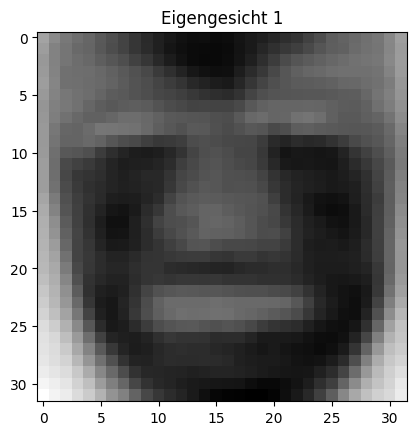

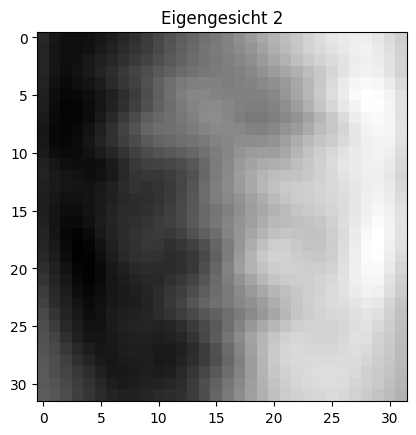

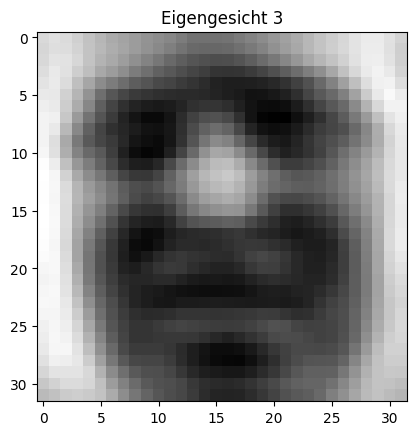

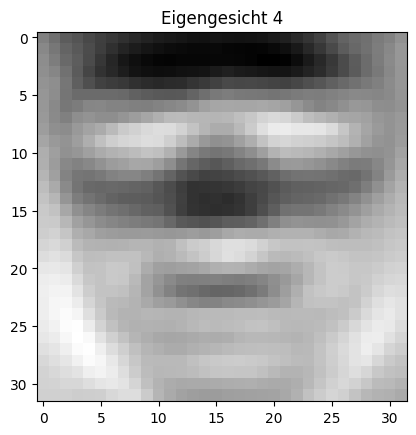

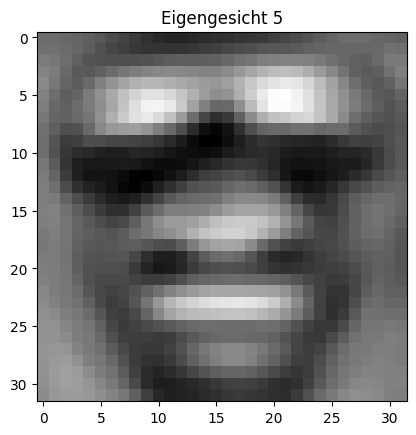

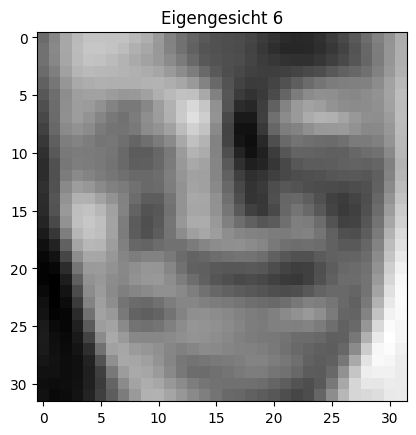

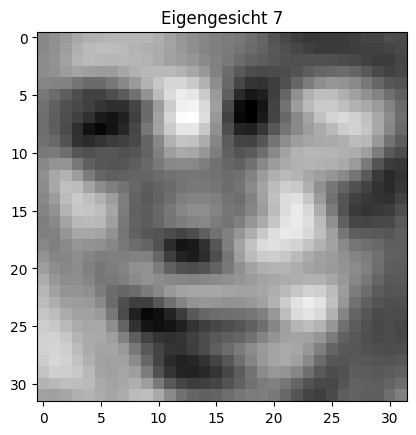

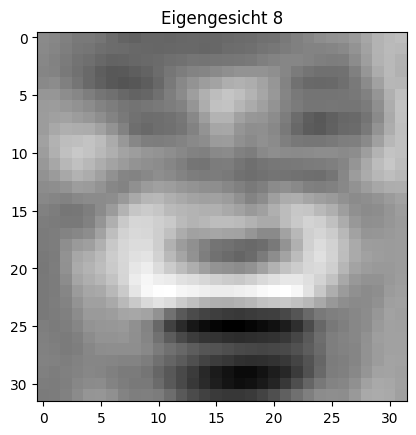

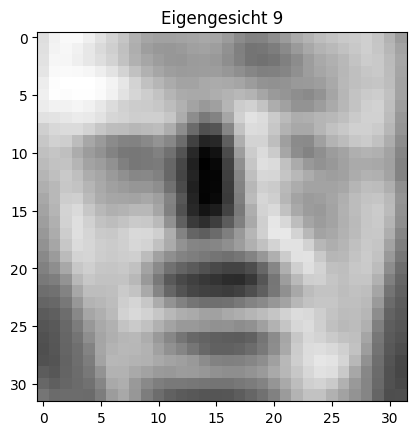

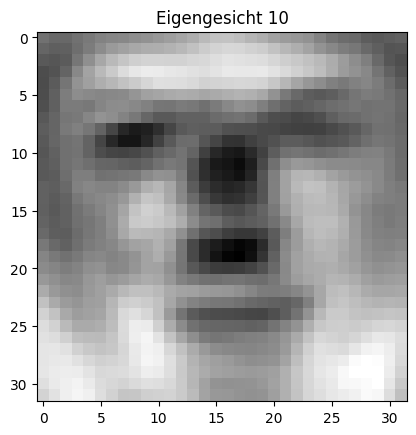

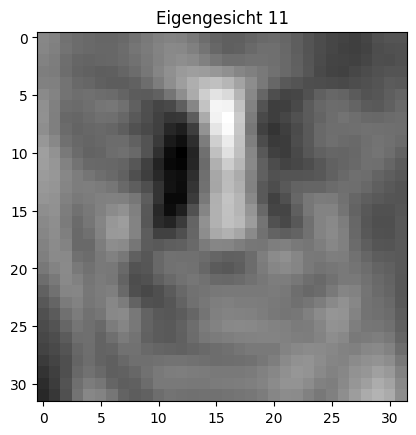

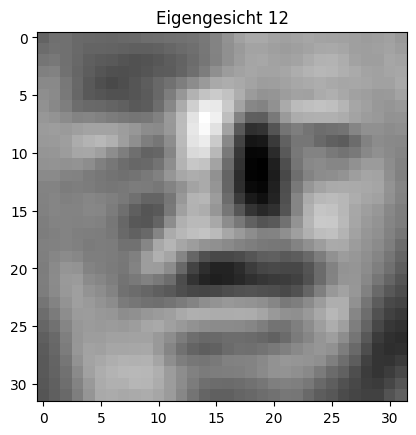

In [12]:
eigenvectors = V[:, :12]

eigenvalue_images = []
for i in range(12):
    eigenvalue_image = eigenvectors[:, i].reshape(32, 32)
    eigenvalue_images.append(eigenvalue_image)

# Visualisieren
for i in range(12):
    plt.imshow(eigenvalue_images[i], cmap='gray')
    plt.title(f'Eigengesicht {i+1}')
    plt.show()

### d) Von den Testbildern wird nun ebenfalls der Mittelwert der Trainingsdaten abgezogen (s. Schritt 1 im PCA-Algorithmus). Projizieren Sie jedes der Trainings- und Testbilder auf die ersten 7 Eigengesichter, d.h. Sie erhalten so für jedes Trainings- und Testbild 7 Merkmale. Die Gesichtserkennung geschieht nun dadurch, dass Sie den euklidischen Abstand des Testbildes in diesem 7-dimensionalen Merkmalsraum zu allen Trainingsbildern berechnen. Die Person des am nächsten liegenden Trainingsbildes (d.h. mit dem minimalen euklidischen Abstand) ist dann (vermutlich) auch die korrekte Person für das Testbild (Nächster-Nachbar-Klassifikator). Welche Bilder werden korrekt klassifiziert, welche Verwechslungen gibt es?

In [13]:
# Testdaten zentrieren
test_data_meaned = pd.DataFrame(np.concatenate(test_data, axis=0)) - np.mean(X, axis=0)
# Testdaten zentrieren
test_data_meaned = pd.DataFrame(test_data) - np.mean(X, axis=0)
train_data_meaned = pd.DataFrame(train_data) - np.mean(X, axis=0)
# Testdaten standardisieren
train_data_std = np.std(train_data_meaned, axis=0)
test_data_standardized = test_data_meaned / train_data_std
# Projektion der Testdaten auf die ersten 7 Eigengesichter
test_data_pca = np.dot(test_data_standardized, V[:,:7])

# Trainingsdaten projeziert auf die ersten 7 Eigengesichter
train_data_pca = X_pca[:,:7]

# Differenzen zwischen den Test- und Trainingsbildern berechnen
differences = train_data_pca - test_data_pca[:, np.newaxis, :]

i = 0
for test_picture in test_data_pca:
    # Differenzen zwischen den Test- und Trainingsbildern berechnen
    differences = train_data_pca - test_picture
    # Euklidischen Abstand für jeden Vektor berechnen
    euclidean_distances = np.linalg.norm(differences, axis=1)
    
    # Bilder mit kleinstem Abstand finden
    min_index = np.argmin(euclidean_distances, axis=0)
    print(f"Soll: {test_data_name[i]}  Ist: {train_data_name[min_index]} ")
    i = i + 1

Soll: Ariel_Sharon  Ist: George_W_Bush 
Soll: Colin_Powell  Ist: Colin_Powell 
Soll: Donald_Rumsfeld  Ist: George_W_Bush 
Soll: George_W_Bush  Ist: George_W_Bush 
Soll: Gerhard_Schroeder  Ist: Donald_Rumsfeld 
Soll: Hugo_Chavez  Ist: Donald_Rumsfeld 
Soll: Tony_Blair  Ist: Hugo_Chavez 


In [14]:
%version_information

Software versions
Python 3.12.0 64bit [MSC v.1935 64 bit (AMD64)]
IPython 8.16.1
OS Windows 11 10.0.22621 SP0
Tue Nov 14 15:55:43 2023 Mitteleuropäische Zeit